In [1]:
import pandas as pd
import os
import string
import matplotlib.pyplot as plt 
import numpy as np
from pybaselines import whittaker
pd.options.mode.chained_assignment = None  # default='warn'

C:\Users\smaslikhov\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\smaslikhov\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\smaslikhov\Anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Datasets forming

In [33]:
def get_whole_dataset(annotation_cols):
    files_in_dir = os.listdir()
    df_ppg_train = pd.DataFrame()
    df_annotation_train = pd.DataFrame()
    # collecting ppg data from files
    for csv in list(filter(lambda x:'PPG' in x and 'csv' in x, files_in_dir)):
        df = pd.read_csv(csv, usecols=['cid', 'ppg_data'])
        df_ppg_train = pd.concat([df_ppg_train, df])
    # collecting annotation data
    else:
        for xlsx in list(filter(lambda x: x[0].lower() not in string.ascii_lowercase and x[0].isalpha(), files_in_dir)):
            df = pd.read_excel(xlsx, usecols=annotation_cols)
            df['Площадка'] = xlsx[:xlsx.find('.')]
            df_annotation_train = pd.concat([df_annotation_train, df])
        df_train = pd.merge(df_ppg_train, df_annotation_train.rename(columns={'Номер ЭКГ/ФПГ': 'cid'}), on='cid')
        # converting string representation of list to list
#         df_train['ppg_data'] = df_train['ppg_data'].apply(lambda x: list(map(float, x.strip('][').split(','))))
    return df_train

In [35]:
annotation_cols = ['Номер пациента', 'Номер ЭКГ/ФПГ', 'Наличие диабета', 'Уровень глюкозы, ммоль/л',
       'Возраст, лет', 'Вес, кг', 'Рост, см', 'Пол', 'SDNN', 'Skewness', 'AMo',
       'SWAI', 'Mo', 'dRR', 'RRNN', 'pNN50', 'SI', 'SATI', 'RMI', 'kurtosis',
       'CV', 'RMSSD', 'NN50', 'LF', 'LF/HF', 'HF, %', 'TP', 'VLF', 'VLF, %',
       'LF, %', 'BR', 'IC', 'HF', 'QT', 'ST', 'PQ', 'QRS', 'P', 'Q', 'R', 'S',
       'T', 'ЧСС, уд./мин.', 'Натощак']

In [36]:
df_all = get_whole_dataset(annotation_cols)

In [40]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2958 entries, 0 to 2957
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   cid                       2958 non-null   int64  
 1   ppg_data                  2958 non-null   object 
 2   Номер пациента            2958 non-null   int64  
 3   Наличие диабета           2958 non-null   int64  
 4   Уровень глюкозы, ммоль/л  2811 non-null   float64
 5   Возраст, лет              2958 non-null   int64  
 6   Вес, кг                   2958 non-null   int64  
 7   Рост, см                  2958 non-null   int64  
 8   Пол                       2958 non-null   int64  
 9   SDNN                      2958 non-null   float64
 10  Skewness                  2958 non-null   float64
 11  AMo                       2958 non-null   float64
 12  SWAI                      2958 non-null   float64
 13  Mo                        2958 non-null   float64
 14  dRR     

In [38]:
df_all.to_csv('unprocessed_dataset.csv', index=False)

## Data preprocessing

**Gaussian filter**

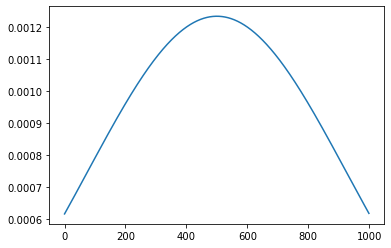

In [17]:
sigRate = 1000
fwhm = 1000 # in ms
k = 500
gauss_time = np.arange(-k,k)
# create Gaussian window
gauswin = np.exp( -(4*np.log(2)*gauss_time**2) / fwhm**2 )

pstPeakHalf = k + np.argmin((gauswin[k:]-.5)**2 )
prePeakHalf = np.argmin( (gauswin-.5)**2 )
empFWHM = gauss_time[pstPeakHalf] - gauss_time[prePeakHalf]

gauss_win = np.exp(-(4*np.log(2)*gauss_time**2) / empFWHM**2 ) 
gauss_win = gauss_win / np.sum(gauss_win)
plt.plot(gauss_win)

Text(0.5, 1.0, 'Gaussian smoothing filter')

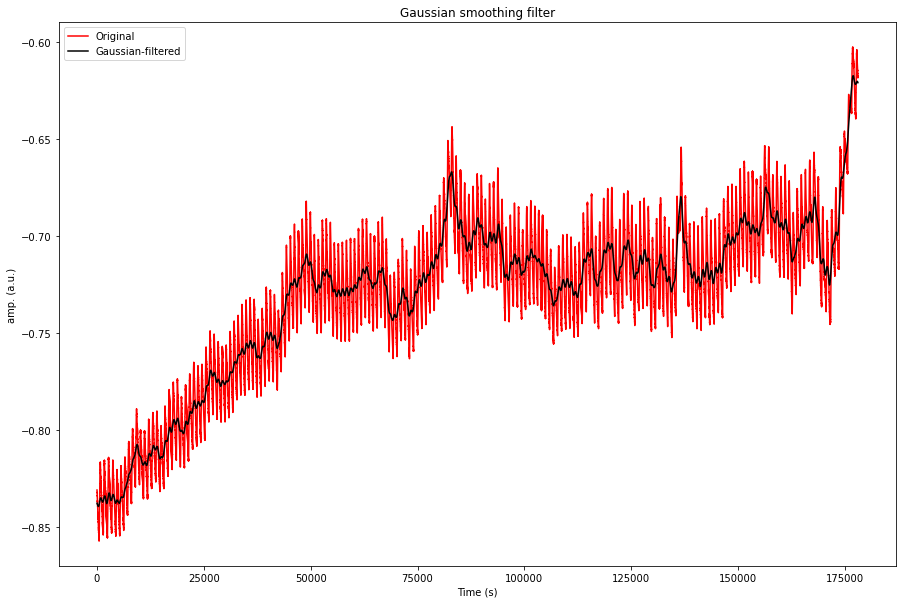

In [18]:
# initialize filtered signal vector
n = len(df_fasting['ppg_data'][0])
signal = np.array(df_fasting['ppg_data'][0])
filtSig_Gauss = np.zeros(n)
# # implement the running mean filter
for i in range(k+1, n-k-1):
    # each point is the weighted average of k surrounding points
    filtSig_Gauss[i] = np.sum(signal[i-k:i+k]*gauss_win )
    
plt.figure(figsize= (15, 10))
plt.plot(signal[1000:-1000],'r',label='Original')
plt.plot(filtSig_Gauss[1000:-1000],'k',label='Gaussian-filtered')
plt.xlabel('Time (s)')
plt.ylabel('amp. (a.u.)')
plt.legend()
plt.title('Gaussian smoothing filter')

**Running mean filter**

Text(0.5, 1.0, 'Running mean filter')

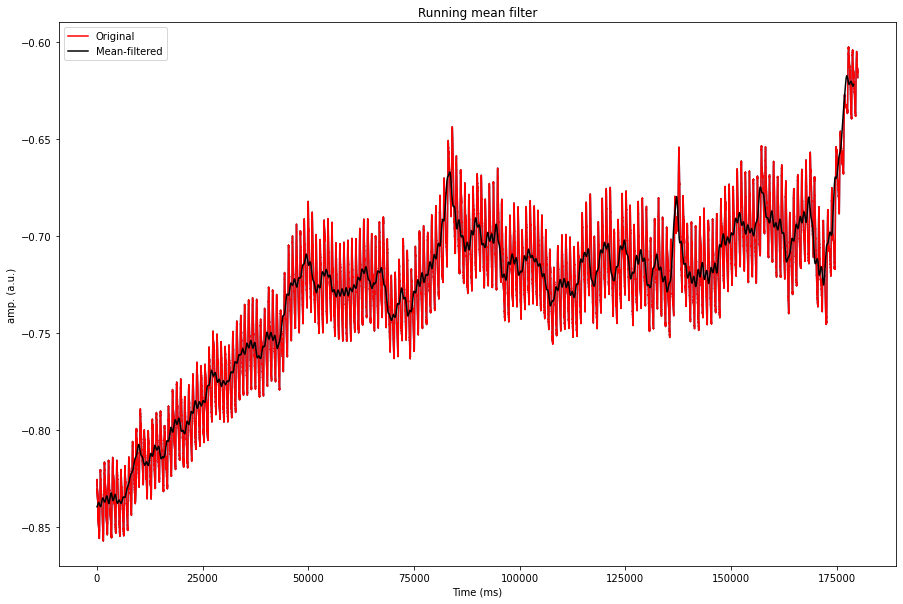

In [19]:
# initialize filtered signal vector
signal = np.array(df_fasting['ppg_data'][0])
N = 1000
# # implement the running mean filter
filtSig = np.convolve(np.array(signal), gauss_win, mode='valid')

plt.figure(figsize= (15, 10))
plt.plot(np.array(df_fasting['ppg_data'][0]))
plt.plot(signal,'r',label='Original')
plt.plot(filtSig,'k',label='Mean-filtered')
plt.xlabel('Time (ms)')
plt.ylabel('amp. (a.u.)')
plt.legend()
plt.title('Running mean filter')

**Asymmetric least squares**

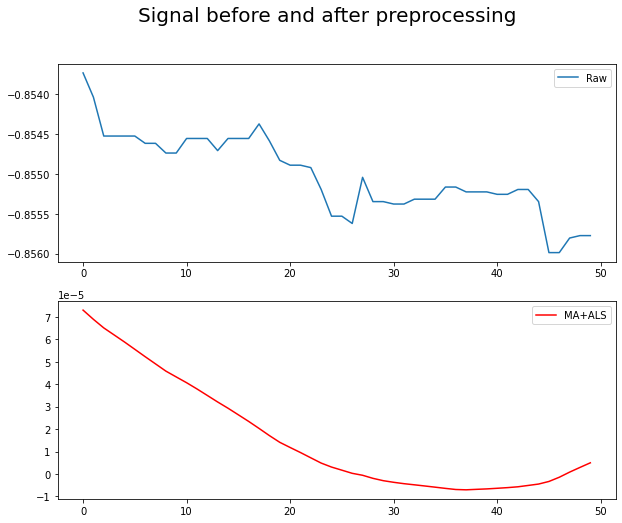

In [8]:
res = np.array(filtSig) - whittaker.iasls(filtSig)[0]
fig = plt.figure( figsize=(10, 8))
fig.suptitle('Signal before and after preprocessing', fontsize=20)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
ax1.plot(df_fasting['ppg_data'][0][500:550], label='Raw')
ax2.plot(res[500:550], color='r', label='MA+ALS')
ax1.legend()
ax2.legend()

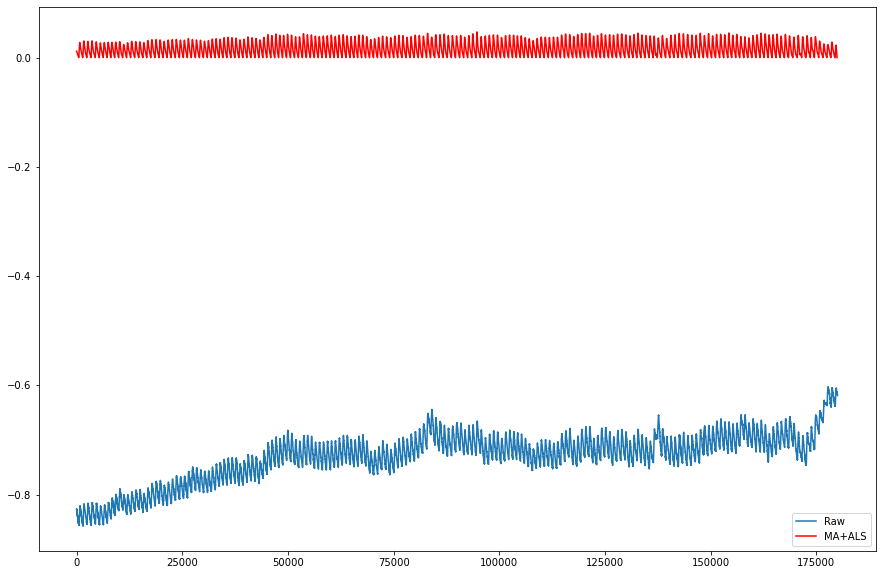

In [239]:
plt.figure(figsize=(15, 10))
res = np.array(filtSig) - whittaker.iasls(filtSig)[0]
plt.plot(np.array(df_fasting['ppg_data'][0]), label='Raw')
plt.plot(res,'r', label='MA+ALS')
plt.legend()

In [2]:
def mov_avg_and_als(signal, width=1000):
    filt_sig = np.convolve(np.array(signal), np.ones(width)/width, mode='valid')
    return list(np.round(filt_sig - whittaker.iasls(filt_sig)[0], 4))